In [1]:
import concurrent.futures
import cylouvain
import matplotlib as mpl
import networkx as nx
import numpy as np
import os
import pandas as pd
import shap
import xgboost as xgb
from matplotlib import pyplot as plt
from matplotlib import cm
from phylib.io.model import load_model
from sklearn.preprocessing import normalize
from umap import UMAP
from umap import umap_ as umap
from wavemap_paper.helper_functions import plot_confusion_matrix
from wavemap_paper.helper_functions import plot_inverse_mapping
from wavemap_paper.helper_functions import train_gridsearch_classifier

C:\Users\short\miniforge3\envs\WaveMAP\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Load the saved data
SAVED_PATH = r"meanWave_clust_rec_fr.npy"  # Path to save the waveform data
data = np.load(SAVED_PATH, allow_pickle=True).item()
waveforms = data['waveforms']
cluster_ids = data['cluster_ids']

In [6]:
# Create a copy of the waveforms array
new_waveforms = waveforms.copy()

# Identify the rows that contain 1
rows_with_1 = np.any(waveforms == 1, axis=1)

# Multiply the identified rows by -1
new_waveforms[rows_with_1] *= -1

In [7]:
RAND_STATE = 42

reducer = umap.UMAP(random_state = RAND_STATE, n_neighbors = 15)

mapper = reducer.fit(new_waveforms)

In [10]:
G = nx.from_scipy_sparse_array(mapper.graph_)

In [11]:
clustering = cylouvain.best_partition(G, resolution = 2)

clustering_solution = list(clustering.values())

adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


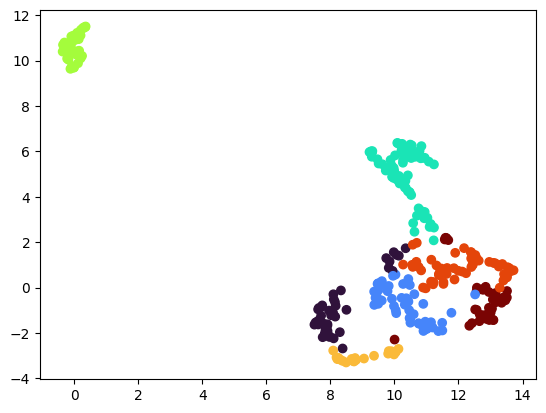

In [12]:
embedding = reducer.fit_transform(new_waveforms)

umap_df = pd.DataFrame(embedding, columns=('x', 'y'))

umap_df['waveform'] = list(new_waveforms)

umap_df['cluster_id'] = clustering_solution

cmap = plt.get_cmap("turbo")

colors = cmap(np.linspace(0, 1, len(set(clustering_solution))))

umap_df['cluster_color'] = [colors[i] for i in clustering_solution]

plt.scatter(umap_df['x'].tolist(), umap_df['y'].tolist(),

marker='o', c=umap_df['cluster_id'].tolist(), cmap='turbo')

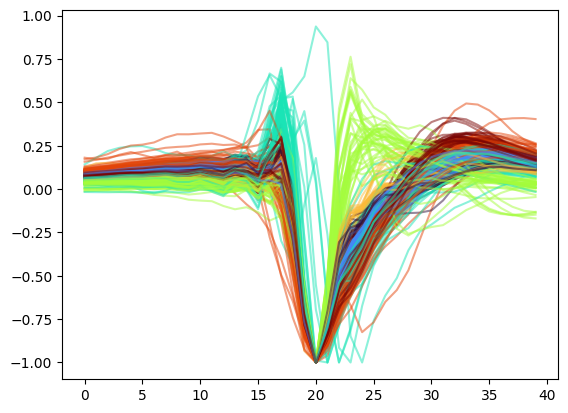

In [13]:
f,arr = plt.subplots(1)

for i,row in enumerate(umap_df['waveform'].tolist()):
    arr.plot(umap_df['waveform'].tolist()[i],c=umap_df['cluster_color'].tolist()[i],alpha=0.5)

In [14]:
umap_df

,x,y,waveform,cluster_id,cluster_color
0,10.349236,1.731203,"[0.1099006, 0.116567135, 0.12440342, 0.1342621...",0,"[0.18995, 0.07176, 0.23217, 1.0]"
1,7.978102,-2.153812,"[0.068219796, 0.072843686, 0.07739481, 0.08312...",0,"[0.18995, 0.07176, 0.23217, 1.0]"
2,10.833803,0.755107,"[0.09019028, 0.09590861, 0.10189682, 0.1097604...",5,"[0.89298, 0.26981, 0.03993, 1.0]"
3,9.606626,0.282016,"[0.084707275, 0.09079722, 0.095418565, 0.10189...",1,"[0.27381, 0.52069, 0.97899, 1.0]"
4,10.245857,5.946361,"[0.060261134, 0.06250456, 0.064926274, 0.06951...",2,"[0.10342, 0.896, 0.715, 1.0]"
...,...,...,...,...,...
330,13.072718,-0.527388,"[0.083370574, 0.08968581, 0.09321125, 0.096058...",6,"[0.4796, 0.01583, 0.01055, 1.0]"
331,11.370606,-1.918636,"[0.08491054, 0.09195461, 0.097288266, 0.101588...",1,"[0.27381, 0.52069, 0.97899, 1.0]"
332,10.749750,5.977310,"[0.06147723, 0.06352104, 0.065786414, 0.071404...",2,"[0.10342, 0.896, 0.715, 1.0]"
333,10.819877,5.694535,"[0.065998554, 0.069440424, 0.073286645, 0.0789...",2,"[0.10342, 0.896, 0.715, 1.0]"


In [16]:
new_waveforms[0]

array([ 0.1099006 ,  0.11656713,  0.12440342,  0.1342621 ,  0.1423753 ,
        0.14698349,  0.15345283,  0.16103794,  0.16350685,  0.16874729,
        0.17984778,  0.17816849,  0.17237459,  0.187303  ,  0.18655801,
        0.15643847,  0.17217287,  0.1536163 , -0.15639983, -0.69080895,
       -1.        , -0.9143426 , -0.710649  , -0.57144874, -0.43530172,
       -0.29278255, -0.1997032 , -0.13555406, -0.06787571, -0.01312747,
        0.02460124,  0.06353808,  0.10577487,  0.14517343,  0.18087366,
        0.20824729,  0.2229658 ,  0.22834478,  0.22732554,  0.21983373],
      dtype=float32)

In [17]:
new_waveforms[1]

array([ 0.0682198 ,  0.07284369,  0.07739481,  0.08312042,  0.08796546,
        0.08951133,  0.09299275,  0.09858026,  0.09717623,  0.09717029,
        0.10737227,  0.10276967,  0.08718994,  0.10471798,  0.11511181,
        0.07202127,  0.08869146,  0.1412946 , -0.11564638, -0.69564915,
       -1.        , -0.74030346, -0.36976287, -0.24078393, -0.19375934,
       -0.09301104, -0.02062935,  0.00917778,  0.05421672,  0.09767398,
        0.10774515,  0.10670733,  0.11958282,  0.14131682,  0.1582869 ,
        0.16407013,  0.16028081,  0.15214369,  0.14212413,  0.13005859],
      dtype=float32)

In [18]:
data.keys()

dict_keys(['waveforms', 'cluster_ids', 'firing_rates', 'recording_names'])

In [19]:
data['waveforms'].shape

(335, 40)

In [20]:
data['cluster_ids'].shape

(335,)

In [21]:
data['firing_rates'].shape

(335,)

In [22]:
data['recording_names'].shape

(335,)

In [26]:
# Create a copy of umap_df
umap_df_detail = umap_df.copy()

# Append firing rates, recording names, and cluster_ids (renamed to unit_id)
umap_df_detail['firing_rate'] = data['firing_rates']
umap_df_detail['recording_name'] = data['recording_names']
umap_df_detail['unit_id'] = data['cluster_ids']

# Display the updated DataFrame
umap_df_detail

,x,y,waveform,cluster_id,cluster_color,firing_rate,recording_name,unit_id
0,10.349236,1.731203,"[0.1099006, 0.116567135, 0.12440342, 0.1342621...",0,"[0.18995, 0.07176, 0.23217, 1.0]",4.813648,20240320_142408_alone_comp_subj_3-3_t5b5_merge...,45.0
1,7.978102,-2.153812,"[0.068219796, 0.072843686, 0.07739481, 0.08312...",0,"[0.18995, 0.07176, 0.23217, 1.0]",0.820515,20240320_142408_alone_comp_subj_3-3_t5b5_merge...,60.0
2,10.833803,0.755107,"[0.09019028, 0.09590861, 0.10189682, 0.1097604...",5,"[0.89298, 0.26981, 0.03993, 1.0]",0.843159,20240320_142408_alone_comp_subj_3-3_t5b5_merge...,67.0
3,9.606626,0.282016,"[0.084707275, 0.09079722, 0.095418565, 0.10189...",1,"[0.27381, 0.52069, 0.97899, 1.0]",1.958041,20240320_142408_alone_comp_subj_3-3_t5b5_merge...,109.0
4,10.245857,5.946361,"[0.060261134, 0.06250456, 0.064926274, 0.06951...",2,"[0.10342, 0.896, 0.715, 1.0]",7.644411,20240320_142408_alone_comp_subj_3-3_t5b5_merge...,124.0
...,...,...,...,...,...,...,...,...
330,13.072718,-0.527388,"[0.083370574, 0.08968581, 0.09321125, 0.096058...",6,"[0.4796, 0.01583, 0.01055, 1.0]",0.804778,20240411_155157_comp_novel_subj_3-1_t3b3_merge...,70.0
331,11.370606,-1.918636,"[0.08491054, 0.09195461, 0.097288266, 0.101588...",1,"[0.27381, 0.52069, 0.97899, 1.0]",1.037401,20240411_155157_comp_novel_subj_3-1_t3b3_merge...,88.0
332,10.749750,5.977310,"[0.06147723, 0.06352104, 0.065786414, 0.071404...",2,"[0.10342, 0.896, 0.715, 1.0]",9.344763,20240411_155157_comp_novel_subj_3-1_t3b3_merge...,92.0
333,10.819877,5.694535,"[0.065998554, 0.069440424, 0.073286645, 0.0789...",2,"[0.10342, 0.896, 0.715, 1.0]",3.151393,20240411_155157_comp_novel_subj_3-1_t3b3_merge...,94.0


In [32]:
# Select only the columns that should be averaged
columns_to_average = ['x', 'y', 'firing_rate']
waveform_means = umap_df_detail.groupby('cluster_id')['waveform'].apply(lambda x: np.mean(np.vstack(x), axis=0))

# Group by cluster_id and calculate the mean for the selected columns
cluster_averages = umap_df_detail.groupby('cluster_id')[columns_to_average].mean()

# Include the averaged waveforms
cluster_averages['waveform'] = waveform_means

# If cluster_color should be included, it can be taken from one of the rows for each cluster_id
cluster_colors = umap_df_detail.groupby('cluster_id')['cluster_color'].first()

# Combine the averaged DataFrame with the cluster_colors
cluster_averages['cluster_color'] = cluster_colors

# Reset the index if you want cluster_id to be a column
cluster_averages.reset_index(inplace=True)

# Display the resulting DataFrame
cluster_averages

,cluster_id,x,y,firing_rate,waveform,cluster_color
0,0,8.296834,-0.936565,3.190127,"[0.07497758, 0.08104657, 0.08611702, 0.0929668...","[0.18995, 0.07176, 0.23217, 1.0]"
1,1,10.379972,-0.791721,2.597821,"[0.08275753, 0.08873116, 0.093992904, 0.100200...","[0.27381, 0.52069, 0.97899, 1.0]"
2,2,10.348389,4.949466,4.094886,"[0.06145456, 0.06521475, 0.06905148, 0.0754103...","[0.10342, 0.896, 0.715, 1.0]"
3,3,-0.001980,10.592668,13.479945,"[0.02970724, 0.030762237, 0.030788299, 0.03197...","[0.64362, 0.98999, 0.23356, 1.0]"
4,4,9.064189,-3.034598,4.206360,"[0.06557637, 0.069627486, 0.07182912, 0.075320...","[0.98, 0.73, 0.22161, 1.0]"
5,5,12.074739,0.841860,3.157369,"[0.102132015, 0.10861759, 0.115288086, 0.12311...","[0.89298, 0.26981, 0.03993, 1.0]"
6,6,12.706931,-0.480688,3.869009,"[0.07881407, 0.082053356, 0.08489025, 0.088750...","[0.4796, 0.01583, 0.01055, 1.0]"


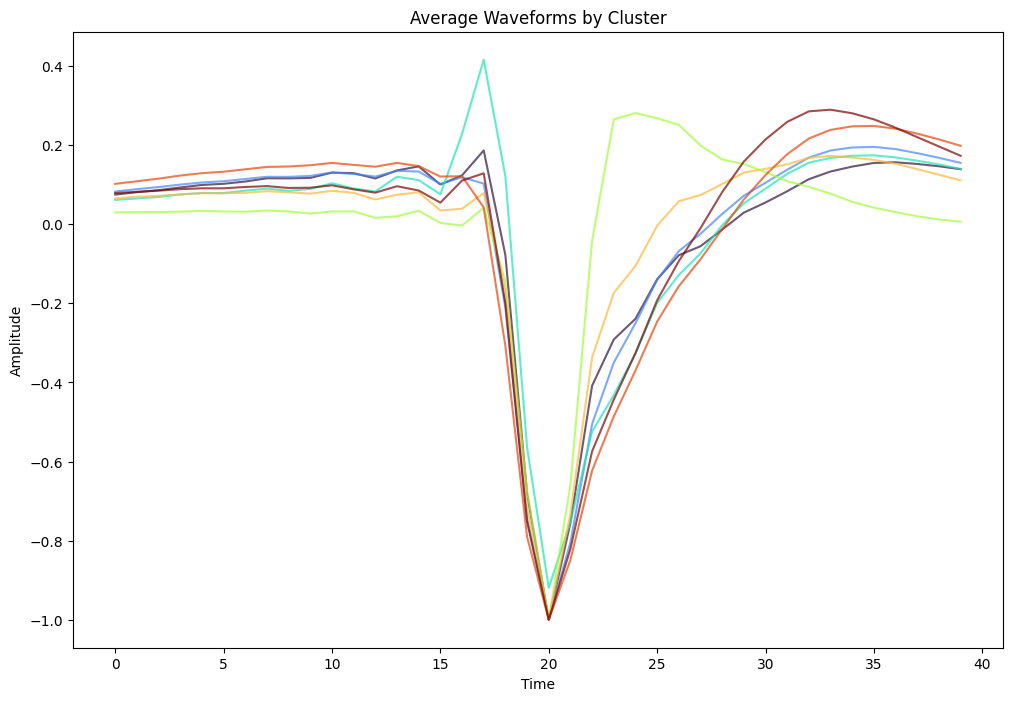

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Plot the waveforms from cluster_averages
plt.figure(figsize=(12, 8))

for _, row in cluster_averages.iterrows():
    plt.plot(row['waveform'], color=row['cluster_color'], alpha=0.7)

plt.title('Average Waveforms by Cluster')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

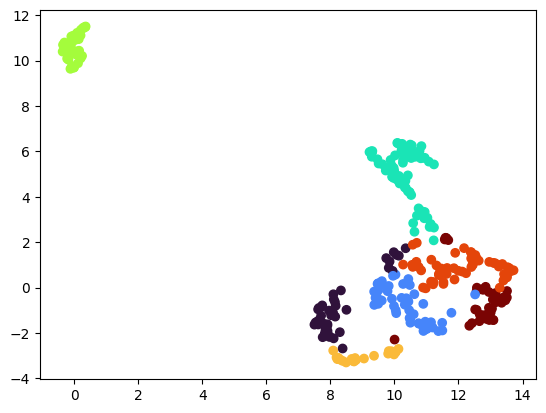

In [35]:
embedding = reducer.fit_transform(new_waveforms)

umap_df = pd.DataFrame(embedding, columns=('x', 'y'))

umap_df['waveform'] = list(new_waveforms)

umap_df['cluster_id'] = clustering_solution

cmap = plt.get_cmap("turbo")

colors = cmap(np.linspace(0, 1, len(set(clustering_solution))))

umap_df['cluster_color'] = [colors[i] for i in clustering_solution]

plt.scatter(umap_df['x'].tolist(), umap_df['y'].tolist(),

marker='o', c=umap_df['cluster_id'].tolist(), cmap='turbo')

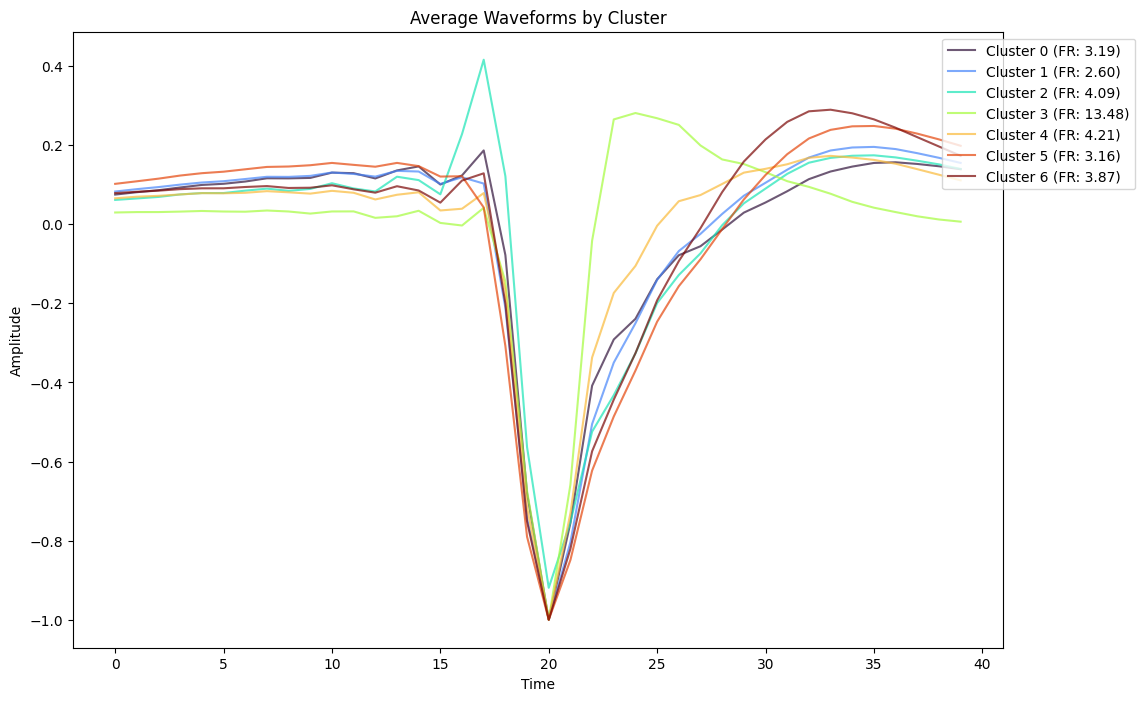

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Plot the waveforms from cluster_averages
plt.figure(figsize=(12, 8))

# Iterate over each row to plot the waveform and prepare legend entries
legend_entries = []
for _, row in cluster_averages.iterrows():
    plt.plot(row['waveform'], color=row['cluster_color'], alpha=0.7)
    legend_entries.append(f"Cluster {row['cluster_id']} (FR: {row['firing_rate']:.2f})")

# Adding the legend
plt.legend(legend_entries, loc='upper right', bbox_to_anchor=(1.15, 1))

plt.title('Average Waveforms by Cluster')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

In [37]:
# Count the occurrences of each cluster_id
cluster_id_counts = umap_df['cluster_id'].value_counts()

# Display the result
cluster_id_counts

2    74
5    59
1    54
0    44
3    41
6    40
4    23
Name: cluster_id, dtype: int64

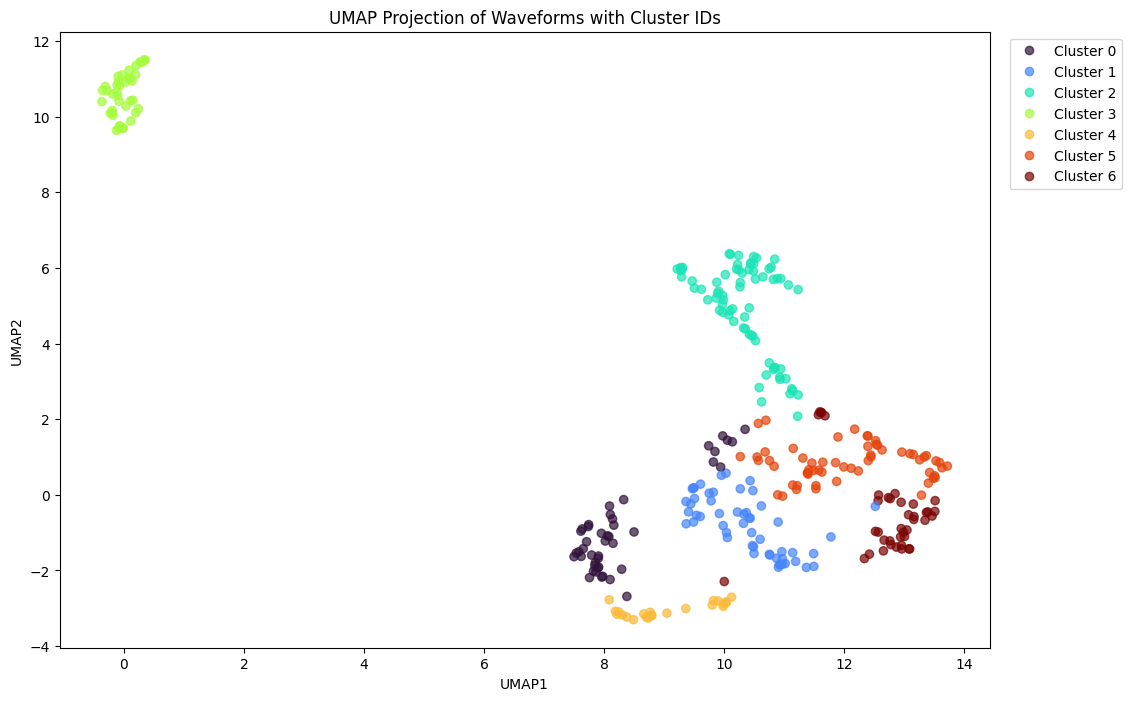

In [39]:
# Assuming new_waveforms and clustering_solution are defined as before
reducer = UMAP(random_state=42, n_neighbors=15)

# Perform UMAP embedding
embedding = reducer.fit_transform(new_waveforms)

# Create a DataFrame for the embedding
umap_df = pd.DataFrame(embedding, columns=('x', 'y'))

# Add the waveform, cluster_id, and cluster_color columns
umap_df['waveform'] = list(new_waveforms)
umap_df['cluster_id'] = clustering_solution

# Create colors for each cluster_id
cmap = plt.get_cmap("turbo")
colors = cmap(np.linspace(0, 1, len(set(clustering_solution))))
umap_df['cluster_color'] = [colors[i] for i in clustering_solution]

# Create the scatter plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(umap_df['x'], umap_df['y'], marker='o', c=umap_df['cluster_id'], cmap='turbo', alpha=0.7)

# Create legend entries for each cluster_id
legend_entries = []
for cluster_id in sorted(umap_df['cluster_id'].unique()):
    legend_entries.append(f"Cluster {cluster_id}")

# Add the legend
plt.legend(handles=scatter.legend_elements()[0], labels=legend_entries, loc='upper right', bbox_to_anchor=(1.15, 1))

plt.title('UMAP Projection of Waveforms with Cluster IDs')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.show()

In [51]:
def calculate_spike_duration(waveform, threshold=0):
    """
    Calculate the spike duration in milliseconds.
    
    Parameters:
    waveform (array): The waveform array.
    threshold (float): The threshold to determine the start and end of the spike.
    
    Returns:
    float: Spike duration in milliseconds.
    """
    # Find the indices where the waveform crosses the threshold
    above_threshold = waveform > threshold
    crossing_points = np.where(np.diff(above_threshold.astype(int)))[0]
    
    if len(crossing_points) >= 2:
        # The duration is the difference between the first and last crossing point
        duration_samples = crossing_points[-1] - crossing_points[0]
    else:
        # If there are less than 2 crossing points, the spike duration is zero
        duration_samples = 0
    
    # Convert the duration from samples to milliseconds
    duration_ms = duration_samples * 0.00005 * 1000  # 0.00005 seconds per sample
    
    return duration_ms

# Calculate and print spike durations
for i, waveform in enumerate(cluster_averages['waveform']):
    duration = calculate_spike_duration(waveform)
    print(f"Spike duration for waveform {i}: {duration:.2f} ms")

Spike duration for waveform 0: 0.55 ms
Spike duration for waveform 1: 0.50 ms
Spike duration for waveform 2: 0.50 ms
Spike duration for waveform 3: 0.35 ms
Spike duration for waveform 4: 0.40 ms
Spike duration for waveform 5: 0.55 ms
Spike duration for waveform 6: 0.50 ms
